<a href="https://colab.research.google.com/github/kushi0203/Deep-Learning/blob/main/DL_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Output saved to /content/detected_images/detected_images (3).jpg
Detections logged to /content/logs/images (3).json


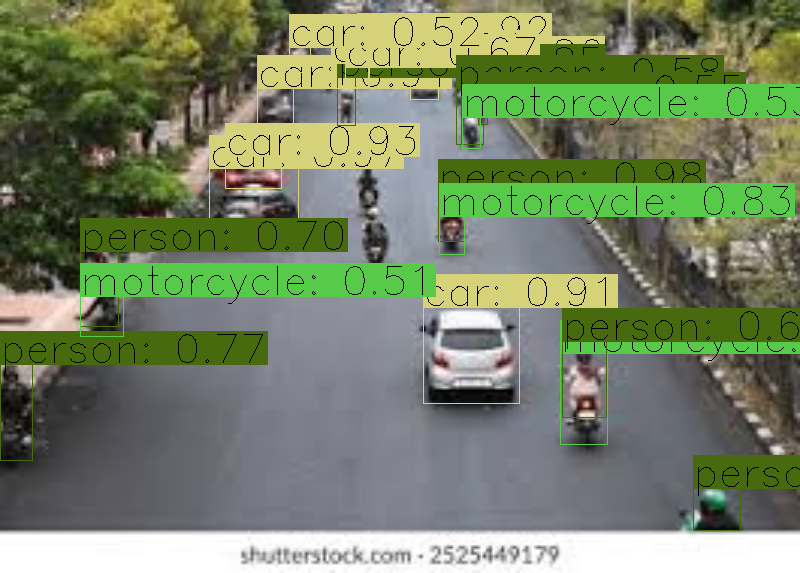

In [10]:
import os
import json
import torch
import torchvision
from torchvision.transforms import functional as F
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the Faster R-CNN model pretrained on COCO
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
    model.eval()
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle',
    'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
    'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Assign unique colors to each category
np.random.seed(42)
LABEL_COLORS = {label: tuple(np.random.randint(0, 255, 3).tolist()) for label in COCO_INSTANCE_CATEGORY_NAMES}

def detect_objects(image_path, confidence_threshold=0.5, max_size=800, save_path=None, log_path=None):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from '{image_path}'. Please check the file path and ensure the image exists.")
        return None

    # Calculate aspect ratio for resizing
    h, w = image.shape[:2]
    scale = max_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    image = cv2.resize(image, (new_w, new_h))

    # Make a copy of the original image for drawing
    original_image = image.copy()

    # Convert to tensor and normalize
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        predictions = model(image_tensor)

    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    detections = []  # To log detections
    # Draw bounding boxes for high-confidence detections
    for i, box in enumerate(boxes):
        if scores[i] >= confidence_threshold:
            label = COCO_INSTANCE_CATEGORY_NAMES[labels[i]]
            score = scores[i]
            start_point = (int(box[0]), int(box[1]))
            end_point = (int(box[2]), int(box[3]))

            # Use unique colors for each label
            color = LABEL_COLORS[label]

            # Dynamic box thickness and font scale
            box_thickness = max(1, int(0.005 * max(h, w)))
            font_scale = 0.005 * max(h, w)

            # Draw bounding box and label
            cv2.rectangle(original_image, start_point, end_point, color, box_thickness)
            text = f"{label}: {score:.2f}"
            text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, box_thickness)
            text_w, text_h = text_size
            cv2.rectangle(original_image, start_point, (start_point[0] + text_w, start_point[1] - text_h - 4), color, -1)
            cv2.putText(original_image, text, (start_point[0], start_point[1] - 2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), box_thickness)

            # Log the detection
            detections.append({
                "label": label,
                "score": float(score),
                "box": [int(box[0]), int(box[1]), int(box[2]), int(box[3])]
            })

    # Save the output if save_path is provided
    if save_path:
        cv2.imwrite(save_path, original_image)
        print(f"Output saved to {save_path}")

    # Log detections if log_path is provided
    if log_path:
        with open(log_path, 'w') as log_file:
            json.dump(detections, log_file, indent=4)
        print(f"Detections logged to {log_path}")

    return original_image

if __name__ == "__main__":
    IMAGE_PATH = "/content/images (3).jpg"  # Change this to your image path (or folder)
    SAVE_DIR = "/content/detected_images/"  # Folder to save processed images
    LOG_DIR = "/content/logs/"  # Folder to save detection logs

    os.makedirs(SAVE_DIR, exist_ok=True)
    os.makedirs(LOG_DIR, exist_ok=True)

    # Check if IMAGE_PATH is a directory or single file
    if os.path.isdir(IMAGE_PATH):
        # Process all images in the directory
        for image_name in os.listdir(IMAGE_PATH):
            image_path = os.path.join(IMAGE_PATH, image_name)
            if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue  # Skip non-image files
            save_path = os.path.join(SAVE_DIR, f"detected_{image_name}")
            log_path = os.path.join(LOG_DIR, f"{os.path.splitext(image_name)[0]}.json")
            detected_image = detect_objects(image_path, confidence_threshold=0.5, save_path=save_path, log_path=log_path)

            # Display the output if the image is detected
            if detected_image is not None:
                cv2_imshow(detected_image)
    else:
        # Process a single image
        if not IMAGE_PATH.lower().endswith(('.png', '.jpg', '.jpeg')):
            print("The provided image path is not an image file.")
        else:
            save_path = os.path.join(SAVE_DIR, f"detected_{os.path.basename(IMAGE_PATH)}")
            log_path = os.path.join(LOG_DIR, f"{os.path.splitext(os.path.basename(IMAGE_PATH))[0]}.json")
            detected_image = detect_objects(IMAGE_PATH, confidence_threshold=0.5, save_path=save_path, log_path=log_path)

            # Display the output if the image is detected
            if detected_image is not None:
                cv2_imshow(detected_image)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')